# Neural Network using PyTorch

In this exercise, you will build a neural network using PyTorch, and apply it to a dataset. Our goal in this exercise is not necessarily to obtain the best results on the dataset. We care more about understanding the different parameters, getting a hands-on experience training networks, and monitoring and debugging them. For this reason, I actually recommend that you don’t use a GPU, and run the code on your local machine, for simpler debugging.


You can get relevant code snippets from [the PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) or other sources online. 

## Dataset
We will use the CIFAR-10 dataset.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from collections import Counter
%matplotlib inline

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


First, let's get to know the dataset. Plot a few examples of images and their labels:


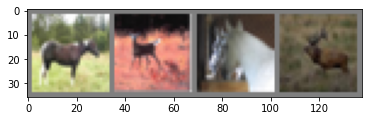

horse  deer horse  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Display the distribution of images per label.

In [6]:
class_count = Counter([i[1] for i in trainloader.dataset])
print(class_count)

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


Is the data balanced? What effect is imbalanced data expected to have on your model's results? How can you work with imbalanced data?

The data is perfectly balanced, each class has 5000 images.

Imbalanced data might lead to the model overfitting for certain classes due to too few examples. 

We can balance the dataset by undersampling classes that have more datapoints, or we can oversample the underrepresented classes by generating synthetic examples of the rarer datapoints.  

**NOTE:** It's a good practice when working on Neural Networks to start with a very small dataset and overfit on it. While we don't specifically ask you to do so in the sections below, we recommend that you take this approach, and first write and run your code using easy to use and debug platform, on a small dataset.

## Build your own CNN classifier
In this section, you will develop your own CNN classifier.

This is meant as an opportunity to get more experience building your own NN architectures using PyTorch, and our focus is on making sure you rewrite and review the needed code and not on obtaining optimal performance. That being said, within the limits of the time you have, try to come up with a NN architecture and hyperparameters that would achieve nice results on the dataset.  
We do recommend that you keep this to only 3-4 Conv layers and 1-2 fully connected layers.

If you want a starting point, you can create this network:

```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```

When training the network, use the Adam optimizer.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120, bias=True)
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 2
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.
run = True
for epoch in range(epochs):  # loop over the dataset multiple times
    if run is False:
        break
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

########################################################################
# Let's quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Tensorboard
TensorBoard provides visualization and tooling for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling programs

Tensorboard worked originally with Tensorflow but can now be used with PyTorch as well.  
You can embed a tensorboard widget in a Jupyter Notebook, although if you're not using Google Colab we recommend that you open tensorboard separately.

To get started with Tensorboard, please read the following pages:

PyTorch related:
1. https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
1. https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e
1. https://towardsdatascience.com/https-medium-com-dinber19-take-a-deeper-look-at-your-pytorch-model-with-the-new-tensorboard-built-in-513969cf6a72
1. https://pytorch.org/docs/stable/tensorboard.html
1. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard

Tensorflow related:
1. https://itnext.io/how-to-use-tensorboard-5d82f8654496
1. https://www.datacamp.com/community/tutorials/tensorboard-tutorial
1. https://medium.com/@anthony_sarkis/tensorboard-quick-start-in-5-minutes-e3ec69f673af
1. https://www.guru99.com/tensorboard-tutorial.html
1. https://www.youtube.com/watch?time_continue=1&v=s-lHP8v9qzY&feature=emb_logo
1. https://www.youtube.com/watch?v=pSexXMdruFM


### Starting Tensorboard
Jupyter Notebook has extensions for displaying TensorBoard inside the notebook. Still, I recommend that you run it separately, as it tends to get stuck in notebooks.

The syntax to load TensorBoard in a notebook is this:
```python
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs
```

In the shell, you can instead run:
```
tensorboard --logdir ./logs
```

In [0]:
# default `log_dir` is "runs" - we'll be more specific here
writer1 = SummaryWriter('runs/CIFAR10_experiment_1')

### Show images using TensorBoard

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

# write to tensorboard
writer1.add_image('four_CIFAR10_images', img_grid)

### Inspect the model graph
You can print a network object to find useful information about it:

In [0]:
print(net)

TensorBoard can help visualize the network graph. It takes practice to read these.  

Write the graph to TensorBoard and review it.

In [0]:
writer1.add_graph(net, images)
writer1.close()

You can also use the package `torchsummary` for a fuller info on the model:

In [0]:
# !pip install torchsummary

In [0]:
channels=3; H=32; W=32
summary(net, input_size=(channels, H, W))

## Train the network
Next, we'll train the network. In the training loop, log relevant metrics that would allow you to plot in TensorBoard:

1. The network loss
1. Train and test error
1. Average weight in the first layer
1. Histogram of weights in the first layer

In [0]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [0]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

running_loss = 0.0
for epoch in range(epochs):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer1.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer1.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
            
            net.eval()
            test_loss = 0.0
            for test in testloader:
                inputs, labels = test
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            writer1.add_scalar('test loss',
                               test_loss / len(testloader),
                               epoch * len(trainloader) + i)
            net.train()
    writer1.add_histogram('conv1_bias', net.conv1.bias, epoch)
    writer1.add_histogram('conv1_weight', net.conv1.weight, epoch)
    writer1.add_histogram('conv1_weight_grad', net.conv1.weight.grad, epoch)

print('Finished Training')

### Precision-Recall Curve
Use TensorBoard to plot the precision-recall curve:

In [0]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer1.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer1.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

### Display Model Errors
A valuable practice is to review errors made by the model in the test set. These might reveal cases of bad preprocessing or lead to come up with improvements to your original model.

Show 12 images of errors made by the model. For each, display the true and predicted classes, and the model confidence in its answer.

In [0]:
n = 12
f = []
for i, data in enumerate(testloader, 0):
    if n > 0:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        preds, probs = images_to_probs(net, inputs)
        for idx in np.arange(len(labels)):
            prob = round(probs[idx] * 100.0, 2)
            pred = classes[preds[idx]]
            true = classes[labels[idx]]
            if pred != true:
                f.append([inputs[idx], pred, prob, true])
                n -= 1
            else:
                continue

In [0]:
fig = plt.figure(figsize=(12, 48))
for i, row in enumerate(f[0:12]):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])
    matplotlib_imshow(row[0], one_channel=True)
    ax.set_title(f"{row[1]}, {row[2]}%\n(label: {row[3]})", color="red")
fig.show()

In [0]:
writer1.add_figure(f'Examples of Errors', fig)

## Batch Normalization
In this section, we'll add a Batch Norm layer to your network.  
Use TensorBoard to compare the network's convergence (train and validation loss) with and without Batch Normalization.

In [0]:
writer2 = SummaryWriter('runs/CIFAR10_experiment_without_BN')
writer3 = SummaryWriter('runs/CIFAR10_experiment_with_BN')

In [0]:
class BN_Net(Net):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120, bias=True)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x


net1 = Net()
bn_net = BN_Net()

In [0]:
channels=3; H=32; W=32
summary(bn_net, input_size=(channels, H, W))

In [0]:
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(net1.parameters(), lr=0.001)
criterion_bn = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(bn_net.parameters(), lr=0.001)

running_loss1 = 0.0
running_loss_bn= 0.0
for epoch in range(epochs):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer1.zero_grad()
        optimizer_bn.zero_grad()

        # forward + backward + optimize
        outputs1 = net1(inputs)
        loss1 = criterion1(outputs1, labels)
        loss1.backward()
        optimizer1.step()
        
        running_loss1 += loss1.item()
        
        outputs_bn = bn_net(inputs)
        loss_bn = criterion_bn(outputs_bn, labels)
        loss_bn.backward()
        optimizer_bn.step()
        
        running_loss_bn += loss_bn.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            
            # ...log the running loss
            writer2.add_scalar('training loss',
                            running_loss1 / 1000,
                            epoch * len(trainloader) + i)


            running_loss1 = 0.0
            
            net1.eval()
            
            writer3.add_scalar('training loss',
                            running_loss_bn / 1000,
                            epoch * len(trainloader) + i)
            
            running_loss_bn = 0.0
            
            bn_net.eval()
            
            test_loss1 = 0.0
            test_loss_bn = 0.0
            for test in testloader:
                inputs_test, labels_test = test
                outputs1 = net1(inputs_test)
                outputs_bn = bn_net(inputs_test)
                loss1 = criterion1(outputs1, labels_test)
                loss_bn = criterion_bn(outputs_bn, labels_test)
                test_loss1 += loss1.item()
                test_loss_bn += loss_bn.item()
            
            writer2.add_scalar('test loss',
                               test_loss1 / len(testloader),
                               epoch * len(trainloader) + i)
            writer3.add_scalar('test loss', 
                               test_loss_bn / len(testloader),
                               epoch * len(trainloader) + i)
            net1.train()
            bn_net.train()
            
print('Finished Training')

Use TensorBoard to plot the distribution of activations with and without Batch Normalization.

In [0]:
viz1 = {}
viz2 = {}
def get_activation_distribution1(m, i, o):
    viz1[m] = o

def get_activation_distribution2(m, i, o):
    viz2[m] = o
    
for name, layer in net1._modules.items():
    layer.register_forward_hook(get_activation_distribution1)

for name, layer in bn_net._modules.items():
    layer.register_forward_hook(get_activation_distribution2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

out1 = net1(images)
out2 = bn_net(images)

In [0]:
for m, v in viz1.items():
    writer2.add_histogram(f'Activations', v, epoch)

for m, v in viz1.items():
    writer3.add_histogram(f'Activations', v, epoch)

## Data Augmentation
Augmenting the data is a useful trick to increase the size of the training set and reduce the generalization error.  

Useful resources: 
- [Explanation about augmentation](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)
- The [torchvision transforms documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The [albumentations](https://github.com/albumentations-team/albumentations) repo

Try to think which transformation can be useful for data augmentation for our task?

Flipping data left or right, changing/rotating the angle of the image, adding random noise, and wrap shift

Apply 1 or 2 basic transformations and check how they affect the network's performance:

In [0]:
writer4 = SummaryWriter('runs/CIFAR10_experiment_with_transformations')
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_aug)
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

In [0]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

running_loss = 0.0
for epoch in range(epochs):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader_aug, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer4.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            running_loss = 0.0
            
            net.eval()
            test_loss = 0.0
            for test in testloader:
                inputs, labels = test
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            
            writer4.add_scalar('test loss',
                               test_loss / len(testloader),
                               epoch * len(trainloader) + i)
            net.train()

print('Finished Training')

## Transfer learning using a NN pre-trained on ImageNet
In this section, we will use a pretrained network and build a classifier using it to predict the labels of our task.

You might find these resources useful:
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
- https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72

### Use a frozen pre-trained network
Use a VGG-16 network, including its weights pretrained on ImageNet.  
Use the pretrained network to obtain the distributed representation in the final layer (the one before the output softmax layer). Freeze the network weights, and add 2 fully connected layers on top of it to classify the images.

In [0]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [0]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, len(classes)))
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
print(model.classifier)

### Fine tuning the weights
In this section, we'll unfreeze the pre-trained weights of the network and allow them to change.  
Be careful - when fine-tuning a network, there is a risk that our attempt to allow the network to adapt to the new domain will lead to a "catastrophic forgetting" of what it had previously learnt.

In [0]:
writer5 = SummaryWriter('runs/CIFAR10_experiment_transfer_learning')

In [0]:
# for param in model.parameters():
#     param.requires_grad = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

run = True
for epoch in range(epochs):  # loop over the dataset multiple times
    if run is False:
        break
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer5.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            running_loss = 0.0
            
            model.eval()
            test_loss = 0.0
            for test in testloader:
                inputs, labels = test
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            
            writer5.add_scalar('test loss',
                               test_loss / len(testloader),
                               epoch * len(trainloader) + i)
            model.train()

print('Finished Training')

## Suggested Resources
1. A good explanation of the different losses - https://gombru.github.io/2019/04/03/ranking_loss/
1. A repo with code implementing CNN classifiers, Siamese networks and Triplet loss with different selection regimes for the MNIST and Fashion-MNIST datasets - https://github.com/adambielski/siamese-triplet
1. There are several resources online for the VGG-Face network (see https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf), that include pre-trained weights on a face recognition dataset. The weights are here - http://www.robots.ox.ac.uk/~vgg/software/vgg_face/, and PyTorch models are here - http://www.robots.ox.ac.uk/~albanie/pytorch-models.html, and you can also check out https://github.com/prlz77/vgg-face.pytorch and https://github.com/claudio-unipv/vggface-pytorch.